# Projeto 2 - Ciência dos Dados
## Predição do preço de imóveis brasileiros

Nome: Ananda Julia Galvão Campelo

Nome: Carol Magario de Mattos Barretto

Nome: Rafael Dourado Bastos de Oliveira

___
Carregando as bibliotecas necessárias:

In [574]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os

# Bibliotecas de modelos estatísticos
from scipy import stats

import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score

# Bibliotecas gráficas para facilitar a vizualização dos dados
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display

# Biblioteca que remove os warnings do Jupter Notbook para uma vizualização mais limpa do documento
import warnings
warnings.filterwarnings('ignore')

In [575]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Rafael Dourado\Desktop\Programação\Insper\cdados\22-2c-cd-p2-grupo_dj_lovers\notebooks


Carregando as funções necessárias:

In [576]:
# Função que separa os base de dados em Treino e Teste
def generate_random_train_test(data, percent_train=1, random_seed=1):

    # randam_state = None : dados aleátorios
    data = data.sample(frac=1.0, random_state=random_seed)

    n_real = len(data)
    n_treino = math.floor(n_real * percent_train)

    train = data.iloc[:n_treino].reset_index(drop=True)
    test = data.iloc[n_treino:].reset_index(drop=True)

    print('Bases de Treino e Teste geradas com sucesso!')
    print(f'A base de Treino possui {train.shape[0]} conjuntos de dados\nA base de Teste possui {test.shape[0]} conjuntos de dados')
    return train, test


Carregando a base com todos dados:

In [577]:
path = '../data/'
filename = 'houses_to_rent.csv'

data = pd.read_csv(path+filename, sep=",")

* *city*: Cidade onde o imóvel está localizada
* *area*: Area do imovel [m²]
* *rooms*: Número de quartos 
* *bathroom*: Número de banheiros
* *parking spaces*: Número de vagas no estacionamento
* *floor*: Andar em que está localizado
* *animal*: Aceita animais? [acept/not acept]
* *furniture*: Está Mobilhada? [furnished/not furnished]
* *hoa*: Valor do Condominio [R$]
* *rent amount*: Valor do Aluguel [R$]
* *property tax*: IPTU [R$]
* *fire insurance*: Seguro Incendio [R$]
* *total*: Valor Total do Imóvel [R$]


In [578]:
data.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


____
### Primeiras Simplificações

Um estudo rápido dos dados revelou a variavel  `total` é composta da soma das variáveis `hoa`, `rent_amount`, `property_tax` e `fire_insurance`. Por isso, uma simplificação inicial do modelo que tentará descobrir o valor de uma apartamento será utilizar como **variavel Target** o `rent_amount` (valor do aluguel) e descartar as demais variaveis supracitadas durante a analise.

In [579]:
data = data.drop(['hoa', 'property_tax', 'fire_insurance', 'total'], axis=1)
data.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
2,Porto Alegre,80,1,1,1,6,acept,not furnished,2800
3,Porto Alegre,51,2,1,0,2,acept,not furnished,1112
4,São Paulo,25,1,1,0,1,not acept,not furnished,800


 Inicialmente iremos trabalhar apenas com variaveis qualitativas para fins de simplificação inicial do Modelo. Para isso, as váriaveis  `city`, `animal` e `furniture` serão desconsideradas nessa primeira iteração. Além disso, a variavel `floor` possui  alguns valores "**-**" que representa os apartamentos localizados no térreo, como queremos trabalhar apenas com variaveis quantitativas iremos substituir esses valores por "**0**".

In [580]:
# As variaveis `animal` e `furniture` são variaveis qualitativas que possuem apenas dois valores: 
# `possui/aceita` e não `possui/não aceita`. Logo, para padronizar essas variaveis, substituiremos 
# esses valores por `True` e `False`, respectivamente.

# data.loc[(data['animal'] == 'acept'), 'animal'] = True
# data.loc[(data['animal'] == 'not acept'), 'animal'] = False
# data['animal'] = data['animal'].astype('boolean')

# data.loc[(data['furniture'] == 'furnished'), 'furniture'] = True
# data.loc[(data['furniture'] == 'not furnished'), 'furniture'] = False
# data['furniture'] = data['furniture'].astype('boolean')

In [581]:
data.loc[(data['floor'] == '-'), 'floor'] = 0
data['floor'] = data['floor'].astype('int64')

quantitative_data = data[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'rent_amount']]

quantitative_data.head()

,area,rooms,bathroom,parking_spaces,floor,rent_amount
0,70,2,1,1,7,3300
1,320,4,4,0,20,4960
2,80,1,1,1,6,2800
3,51,2,1,0,2,1112
4,25,1,1,0,1,800


_____
### Análise Exploratória

In [582]:
quantitative_data.describe().round(2)

,area,rooms,bathroom,parking_spaces,floor,rent_amount
count,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00
mean,149.22,2.51,2.24,1.61,5.04,3896.25
std,537.02,1.17,1.41,1.59,5.35,3408.55
min,11.00,1.00,1.00,0.00,0.00,450.00
25%,56.00,2.00,1.00,0.00,1.00,1530.00
50%,90.00,2.00,2.00,1.00,3.00,2661.00
75%,182.00,3.00,3.00,2.00,8.00,5000.00
max,46335.00,13.00,10.00,12.00,51.00,45000.00


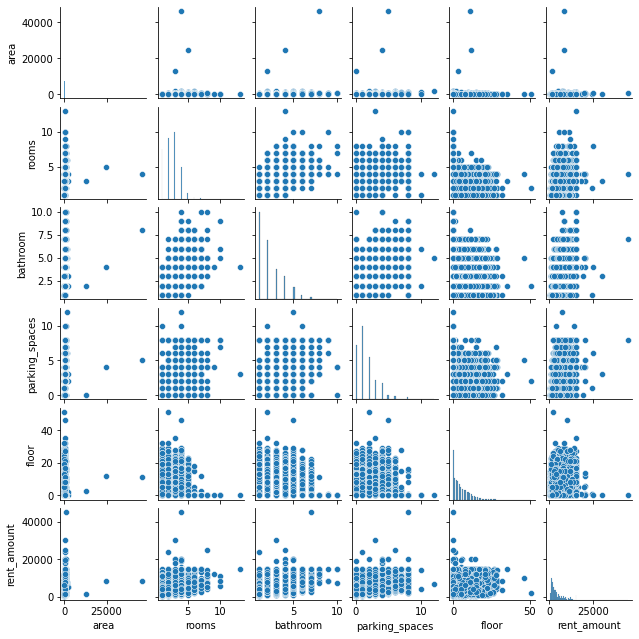

In [606]:
display(sn.pairplot(quantitative_data, height=1.5))

____
### Primeira Iteração

Com exposto nas explicações e analises acima a primeira iteração do modelo para prever o **valor do aluguel de um apartamento (rent_amount)**, nossa `Variável Target` serão usadas como `Variáveis Features` apenas variaveis quantitativas, são elas:
 * *area*;
 * *rooms*;
 * *bathroom*;
 * *parking spaces*;
 * *floor*;

In [584]:
# Separando o Base de dados em bases de treino e teste
train, test = generate_random_train_test(quantitative_data, percent_train=0.7)

X_train = train[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_train = train['rent_amount']

X_test = test[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_test = test['rent_amount']

Bases de Treino e Teste geradas com sucesso!
A base de Treino possui 7484 conjuntos de dados
A base de Teste possui 3208 conjuntos de dados


_____
## Modelos de Predição 


In [585]:
errors = pd.DataFrame()
errors['type'] = ['mse', 'r2']

### Regressão Linear Multipla


In [586]:
# Função de regressão
def linear_regress(Y,X):
    
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [587]:
#Predict no teste
linear = linear_regress(y_train, X_train)
y_pred = linear.predict(sm.add_constant(X_test))
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1392.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:52:09   Log-Likelihood:                -68981.
No. Observations:                7484   AIC:                         1.380e+05
Df Residuals:                    7478   BIC:                         1.380e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -296.8664     75.092     -3.953      0.000    -444.068    -149.665
area               0.1064      0.053      2.022      0.043       0.003       0.210
rooms            281.7601     36.667      7.684      0.000     209.882     353.638
bathroom        1111.8071     33.432     33.256      0.000    1046.271    1177.343
parking_spaces   418.9443     25.574     16.382      0.000     368.812     469.077
floor             61.6730      5.321     11.591      0.000      51.242      72.104
==============================================================================
Omnibus:                     2985.277   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26424.665
Skew:                           1.670   Prob(JB):                         0.00
Kurtosis:                      11.578   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [588]:
errors['linear_1'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]
errors

,type,linear_1
0,mse,2488.848656
1,r2,0.482915


### Árvore de Decisão

In [589]:
def decision_tree_regress(X, y):

    result = DecisionTreeRegressor(random_state = 0) # Constroi a árvore
    result.fit(X, y) # Treina a árvore

    return result

In [590]:
# Predict no teste
decision_tree = decision_tree_regress(X_train, y_train)
y_pred = decision_tree.predict(X_test)

In [591]:
errors['decision_tree_1'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]
errors

,type,linear_1,decision_tree_1
0,mse,2488.848656,3242.008148
1,r2,0.482915,0.122609


### Floresta Aleatória

In [592]:
def random_forest_regress(X, y):

    result = RandomForestRegressor(random_state = 0) # Constroi a floresta
    result.fit(X, y) # Treina a floresta

    return result

In [593]:
# Predict no teste
random_forest = random_forest_regress(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [594]:
errors['random_forest_1'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]
errors

,type,linear_1,decision_tree_1,random_forest_1
0,mse,2488.848656,3242.008148,2419.746854
1,r2,0.482915,0.122609,0.511230


### K-Vizinhos Mais Próximos

In [595]:
def K_neighbors_regress(X, y, k):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    result = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    result.fit(X, y)

    return result

In [596]:
K_neighbors = K_neighbors_regress(X_train, y_train, 6000)
y_pred = K_neighbors.predict(X_test)

In [597]:
errors['K_neighbors_1'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]
errors

,type,linear_1,decision_tree_1,random_forest_1,K_neighbors_1
0,mse,2488.848656,3242.008148,2419.746854,3486.738269
1,r2,0.482915,0.122609,0.511230,-0.014854


## Segunda Iteração



In [598]:
percent = 0.90
quantitative_data_no_outliers = quantitative_data.loc[(data['area'] <= data['area'].quantile(percent)) & 
                                                      (data['rent_amount'] <= data['rent_amount'].quantile(percent)), :]


In [599]:
quantitative_data_no_outliers.describe().round(2)

,area,rooms,bathroom,parking_spaces,floor,rent_amount
count,9062.00,9062.00,9062.00,9062.00,9062.00,9062.00
mean,100.63,2.26,1.88,1.25,5.07,2806.17
std,66.77,1.01,1.07,1.21,5.11,1836.20
min,11.00,1.00,1.00,0.00,0.00,450.00
25%,51.00,1.00,1.00,0.00,1.00,1400.00
50%,78.00,2.00,2.00,1.00,4.00,2250.00
75%,130.00,3.00,2.00,2.00,8.00,3677.50
max,300.00,8.00,7.00,10.00,51.00,8950.00


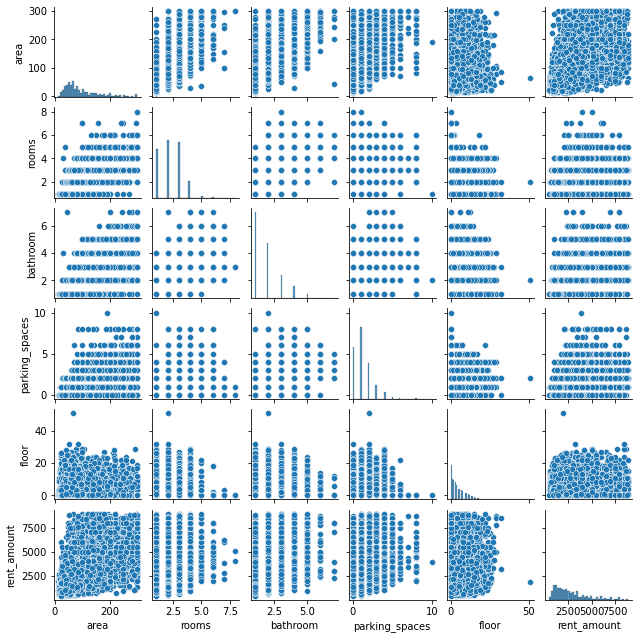

In [605]:
display(sn.pairplot(quantitative_data_no_outliers, height=1.5))

In [601]:
train, test = generate_random_train_test(quantitative_data_no_outliers, percent_train=0.7)

X_train = train[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_train = train['rent_amount']

X_test = test[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_test = test['rent_amount']


Bases de Treino e Teste geradas com sucesso!
A base de Treino possui 6343 conjuntos de dados
A base de Teste possui 2719 conjuntos de dados


In [602]:
linear = linear_regress(y_train, X_train)
y_pred = linear.predict(sm.add_constant(X_test))
linear.summary()

errors['linear_2'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]

decision_tree = decision_tree_regress(X_train, y_train)
y_pred = decision_tree.predict(X_test)

errors['decision_tree_2'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]

random_forest = random_forest_regress(X_train, y_train)
y_pred = random_forest.predict(X_test)

errors['random_forest_2'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]

K_neighbors = K_neighbors_regress(X_train, y_train, 6000)
y_pred = K_neighbors.predict(X_test)

errors['K_neighbors_2'] = [mean_squared_error(y_test, y_pred, squared=False), r2_score(y_test, y_pred)]


In [603]:
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     1057.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:52:31   Log-Likelihood:                -54809.
No. Observations:                6343   AIC:                         1.096e+05
Df Residuals:                    6337   BIC:                         1.097e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            635.1306     47.828     13.279      0.000     541.371     728.890
area              12.6710      0.459     27.634      0.000      11.772      13.570
rooms           -162.1950     26.671     -6.081      0.000    -214.479    -109.910
bathroom         425.3502     26.596     15.993      0.000     373.213     477.487
parking_spaces   136.2340     19.437      7.009      0.000      98.131     174.337
floor             60.0268      3.419     17.559      0.000      53.325      66.728
==============================================================================
Omnibus:                     1081.665   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2158.349
Skew:                           1.032   Prob(JB):                         0.00
Kurtosis:                       4.976   Cond. No.                         360.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [604]:
errors

,type,linear_1,decision_tree_1,random_forest_1,K_neighbors_1,linear_2,decision_tree_2,random_forest_2,K_neighbors_2
0,mse,2488.848656,3242.008148,2419.746854,3486.738269,1316.697015,1776.473741,1408.998437,1799.223352
1,r2,0.482915,0.122609,0.511230,-0.014854,0.460528,0.017993,0.382242,-0.007319


___
## Referências

- https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/
- https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
- https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
- https://medium.com/pursuitnotes/decision-tree-regression-in-6-steps-with-python-1a1c5aa2ee16
- https://stackabuse.com/decision-trees-in-python-with-scikit-learn/